# Convolution Notebook

2019-08-10 Chen-hsiu Huang

The [Overlap add/save](https://www.slideshare.net/GourabGhosh4/overlap-add-overlap-savedigital-signal-processing) method gives us an idea about how to use FFT to accelerate convolution. This method is generally much faster than typical pair-wise multiplication convolution by its definition. But how many performance gain we can get from this kind of FFT accelerated convolution? Let's do some experiments on the 2D convolution and see its result. 

# Convolution Theorem

First of all, let's try prove the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) with the python code. 

## From time domain

In [32]:
import numpy as np
from scipy.fftpack import fft, ifft, fftn, ifftn

x = [0, 0, 3, -1, 0]
h = [1, 1, 2, 1, 1]

X = fft(x)
H = fft(h)
r1 = np.real(ifft(X*H))

r2 = np.convolve(np.hstack((x[1:],x)), h, mode='valid')
print('%s == %s ? %s' % (r1, r2, 'Yes' if np.allclose(r1, r2) else 'No'))


[1. 2. 2. 2. 5.] == [1 2 2 2 5] ? Yes


## From frequency domain

In [31]:
# frequency domain
X = np.array([1.+1.j, 2.+3.j, 1.+2.j, 3.+2.j])
H = np.array([2.+3.j, 1.+1.j, 3.+3.j, 4.+5.j])

Y = X * H
r1 = ifft(Y)
print('r1 = %s' % r1)

x = ifft(X)
h = ifft(H)
x = np.hstack((x[1:], x)) # by default is linear convolution, make it circular
r2 = np.convolve(x,h, mode='valid')
print('r2 = %s' % r2)

print('r1 == r2 ? %s' % ('Yes' if np.allclose(r1, r2) else 'No'))


r1 = [-0.75+10.5j   5.   -1.75j -1.25 -3.5j  -4.   -0.25j]
r2 = [-0.75+10.5j   5.   -1.75j -1.25 -3.5j  -4.   -0.25j]
r1 == r2 ? Yes


## Time domain with different size signal

In [16]:
x = [7, 2, 3, -1, 0, -3, 5, 6]
h = [1, 2, -1]

X = fft(x)
H = fft(h, len(x))
r1 = ifft(X * H)
print('r1 = %s' % r1)
r2 = np.real(np.convolve(np.hstack((x[1:],x)),h,mode='valid'))
r2 = r2[len(r2) - len(x):]
print('r2 = %s' % r2)

print('r1 == r2 ? %s' % ('Yes' if np.allclose(r1, r2) else 'No'))


r1 = [ 1.40000000e+01+0.0000000e+00j  1.00000000e+01-2.2977602e-16j
 -1.11022302e-15+0.0000000e+00j  3.00000000e+00+2.2977602e-16j
 -5.00000000e+00+0.0000000e+00j -2.00000000e+00+6.5840240e-16j
 -1.00000000e+00+0.0000000e+00j  1.90000000e+01-6.5840240e-16j]
r2 = [14 10  0  3 -5 -2 -1 19]
r1 == r2 ? Yes


# Fast Convolution with FFT

Now we see how the FFT can help us on fast convolution. 

The **convolve2d** in **scipy.signal** uses pair-wised multiplication (see the [source code](https://github.com/scipy/scipy/blob/master/scipy/signal/sigtoolsmodule.c) ). Meanwhile, there is also a **fftconvolve** in **scipy.signal** which uses FFT to calculate convolution (see [source code](https://github.com/scipy/scipy/blob/master/scipy/signal/signaltools.py) here). From its documentation: 

> This is generally much faster than convolve for large arrays (n > ~500), but can be slower when only a few output values are needed, and can only output float arrays (int or object array inputs will be cast to float).

For **overlapadd2**, we found a [2D overlap-add with FFT implementation](https://gist.github.com/fasiha/1c46cf98b6b43967b139) on github. Below is its description: 

>    Fast two-dimensional linear convolution via the overlap-add method.
    The overlap-add method is well-suited to convolving a very large array,
    `Amat`, with a much smaller filter array, `Hmat` by breaking the large
    convolution into many smaller `L`-sized sub-convolutions, and evaluating
    these using the FFT. The computational savings over the straightforward
    two-dimensional convolution via, say, scipy.signal.convolve2d, can be
    substantial for large Amat and/or Hmat.

The performance comparison result on my NB shows below: 

| method | convolve2d | fftconvolve | overlapadd2 |
|:-------| -----------:| -----------:| -----------:|
| speed | 3040 ms | 30.1 ms | 94.8 ms |

We can see the FFT based convolution is generally much faster than typical convolution, from 30X to 100X acceleration. The result surprises me a bit because **fftconvolve** is still faster than **overlapadd2**. The **overlapadd2** looks good and ideal, but the user still needs to tweak the size of **L** in order to get the best performance. Maybe **overlapadd2** has the real benefits only when the input matrix is so big that can't be fit into memory and we have split into sub-convolutions. 

One thing to note is, when we use FFT convolution on image processing, there will be a dark borders around the image, due to the zero-padding beyond its boundaries. The **convolve2d** function allows for other types of image boundaries, but is far slower.  

## Reference

There is an article doing 2D convolution benchmark with various convolution libraries: 

https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html

(512, 512)
==> using convolve2d
CPU times: user 2.84 s, sys: 4.87 ms, total: 2.84 s
Wall time: 2.84 s
==> using fftconvolve
CPU times: user 28.4 ms, sys: 11 µs, total: 28.4 ms
Wall time: 28.8 ms
==> using overlapadd2
L = [288 288]
Nfft = [360 360]
CPU times: user 54 ms, sys: 1.89 ms, total: 55.9 ms
Wall time: 56.1 ms


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


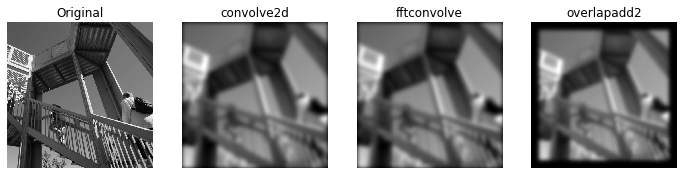

In [75]:
# before you run, eval the cell containing overlapadd2 at the end

from scipy import misc
import scipy.signal as sp
import matplotlib.pyplot as plt

A = misc.ascent()
A = A.astype(float)
print(A.shape)
H = np.outer(sp.gaussian(64, 8), sp.gaussian(64, 8))

print('==> using convolve2d')
%time B1 = sp.convolve2d(A, H, mode='same')
print('==> using fftconvolve')
%time B2 = sp.fftconvolve(A, H, mode='same')
print('==> using overlapadd2')
%time B3 = overlapadd2(A, H)

fig, (ax_orig, ax_conv, ax_fft2conv, ax_ovadd2) = plt.subplots(1, 4, figsize = (12, 8))
ax_orig.imshow(A, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_conv.imshow(B1, cmap='gray')
ax_conv.set_title('convolve2d')
ax_conv.set_axis_off()
ax_fft2conv.imshow(B2, cmap='gray')
ax_fft2conv.set_title('fftconvolve')
ax_fft2conv.set_axis_off()
ax_ovadd2.imshow(B3, cmap='gray')
ax_ovadd2.set_title('overlapadd2')
ax_ovadd2.set_axis_off()
fig.show()


In [71]:
# https://gist.github.com/fasiha/1c46cf98b6b43967b139
def overlapadd2(Amat, Hmat, L=None, Nfft=None, y=None, verbose=False):
    """
    Fast two-dimensional linear convolution via the overlap-add method.
    The overlap-add method is well-suited to convolving a very large array,
    `Amat`, with a much smaller filter array, `Hmat` by breaking the large
    convolution into many smaller `L`-sized sub-convolutions, and evaluating
    these using the FFT. The computational savings over the straightforward
    two-dimensional convolution via, say, scipy.signal.convolve2d, can be
    substantial for large Amat and/or Hmat.
    Parameters
    ----------
    Amat, Hmat : array_like
        Two-dimensional input arrays to be convolved. For computational
        purposes, Amat should be larger.
    L : sequence of two ints, optional
        Length of sub-convolution to use. This should ideally be as large as
        possible to obtain maximum speedup: that is, if you have the memory to
        compute the linear convolution using FFT2, i.e., replacing spatial
        convolution with frequency-domain multiplication, then let `L =
        np.array(Amat.shape) + np.array(Hmat.shape) - 1`. Usually, though, you
        are considering overlap-add because you can't afford a batch transform
        on your arrays, so make `L` as big as you can.
    Nfft : sequence of two ints, optional
        Size of the two-dimensional FFT to use for each `L`-sized
        sub-convolution. If omitted, defaults to the next power-of-two, that
        is, the next power-of-two on or after `L + np.array(Hmat.shape) - 1`.
        If you choose this default, try to avoid `L` such that this minimum, `L
        + np.array(Hmat.shape) - 1`, is just a bit greater than a power-of-two,
        since you'll be paying for a 4x larger FFT than you need.
    y : array_like, optional
        Storage for the output. Useful if using a memory-mapped file, e.g.
    verbose : boolean, optional
        If True, prints a message for each `L`-sized subconvolution.
    Returns
    -------
    y : same as passed in, or ndarray if no `y` passed in
        The `np.array(Amat.shape) + np.array(Hmat.shape) - 1`-sized
        two-dimensional array containing the linear convolution. Should be
        within machine precision of, e.g., `scipy.signal.convolve2d(Amat,
        Hmat, 'full')`.
    Raises
    ------
    ValueError if `L` and `Nfft` aren't two-element, and too small: both
    elements of `L` must be greater than zero, and `Nfft`'s must be greater
    than `L + np.array(Hmat.shape) - 1`. Also if `Amat` or `Hmat` aren't
    two-dimensional arrays, or if `y` doesn't have the correct size to store
    the output of the linear convolution.
    References
    ----------
    Wikipedia is only semi-unhelpful on this topic: see "Overlap-add method".
    """
    M = np.array(Hmat.shape)
    Na = np.array(Amat.shape)

    if y is None:
        y = np.zeros(M + Na - 1, dtype=Amat.dtype)
    elif y.shape != tuple(M + Na - 1):
        raise ValueError('y given has incorrect dimensions', M + Na - 1)

    if L is None:
        nN = _next_regular((Na + M - 1)[0]) / 2
        L = np.array([nN, nN]).astype(int)
    else:
        L = np.array(L)
    print('L = %s' % L)

    if Nfft is None:
        nN = _next_regular((L + M - 1)[0])
        Nfft = np.array([nN, nN])
    else:
        Nfft = np.array(Nfft, dtype=int)
    print('Nfft = %s' % Nfft)

    if not (np.all(L > 0) and L.size == 2):
        raise ValueError('L must have two positive elements')
    if not (np.all(Nfft >= L + M - 1) and Nfft.size == 2):
        raise ValueError('Nfft must have two elements >= L + M - 1 where '
                         'M = Hmat.shape')
    if not (Amat.ndim <= 2 and Hmat.ndim <= 2):
        raise ValueError('Amat and Hmat must be 2D arrays')

    Hf = fftn(Hmat, Nfft)

    (XDIM, YDIM) = (1, 0)
    adjust = lambda x: x                           # no adjuster
    if np.isrealobj(Amat) and np.isrealobj(Hmat):  # unless inputs are real
        adjust = np.real                           # then ensure real
    start = [0, 0]
    endd = [0, 0]
    while start[XDIM] <= Na[XDIM]:
        endd[XDIM] = min(start[XDIM] + L[XDIM], Na[XDIM])
        start[YDIM] = 0
        while start[YDIM] <= Na[YDIM]:
            if verbose:
                print(start)

            endd[YDIM] = min(start[YDIM] + L[YDIM], Na[YDIM])
            yt = adjust(ifftn(Hf * fftn(Amat[start[YDIM] : endd[YDIM], start[XDIM] : endd[XDIM]], Nfft)))

            thisend = np.minimum(Na + M - 1, start + Nfft)
            y[start[YDIM] : thisend[YDIM], start[XDIM] : thisend[XDIM]] += (
                yt[:(thisend[YDIM] - start[YDIM]), :(thisend[XDIM] - start[XDIM])])
            start[YDIM] += L[YDIM]
        start[XDIM] += L[XDIM]
    return y

# https://github.com/scipy/scipy/blob/v0.16.1/scipy/signal/signaltools.py#L206
def _next_regular(target):
    """
    Find the next regular number greater than or equal to target.
    Regular numbers are composites of the prime factors 2, 3, and 5.
    Also known as 5-smooth numbers or Hamming numbers, these are the optimal
    size for inputs to FFTPACK.
    Target must be a positive integer.
    """
    if target <= 6:
        return target

    # Quickly check if it's already a power of 2
    if not (target & (target-1)):
        return target

    match = float('inf')  # Anything found will be smaller
    p5 = 1
    while p5 < target:
        p35 = p5
        while p35 < target:
            # Ceiling integer division, avoiding conversion to float
            # (quotient = ceil(target / p35))
            quotient = -(-target // p35)

            # Quickly find next power of 2 >= quotient
            try:
                p2 = 2**((quotient - 1).bit_length())
            except AttributeError:
                # Fallback for Python <2.7
                p2 = 2**(len(bin(quotient - 1)) - 2)

            N = p2 * p35
            if N == target:
                return N
            elif N < match:
                match = N
            p35 *= 3
            if p35 == target:
                return p35
        if p35 < match:
            match = p35
        p5 *= 5
        if p5 == target:
            return p5
    if p5 < match:
        match = p5
    return match

A = np.random.randn(50, 50)
H = np.random.randn(12, 12)
gold = sp.convolve2d(A, H)
np.allclose(gold, overlapadd2(A, H))

L = [32 32]
Nfft = [45 45]


True